# EmbedEvolution Stage 2: Word2Vec Embeddings

Welcome to the second stage of EmbedEvolution! We now explore Word2Vec, a highly influential model that learns static word embeddings from local word co-occurrence statistics. Unlike RNNs which process sequences to generate potentially contextual (though limited) representations, Word2Vec assigns a single, fixed vector to each word in the vocabulary.

**Goal:** Understand how Word2Vec captures semantic similarities, its efficiency, and its inherent limitations, particularly its static nature and lack of true contextual understanding compared to sequence models.

## 1. Setup and Imports

Import necessary libraries. We'll use `gensim` for Word2Vec.
`nltk` is useful for tokenization.

In [8]:
import numpy as np
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
import nltk # Natural Language Toolkit
from nltk.tokenize import sent_tokenize, word_tokenize # Ensure this is imported to be used below
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity # For manual similarity if needed

# Download nltk resources if not already present (run once)
try:
    # Attempt to use a function that requires 'punkt' to see if it's available
    _ = sent_tokenize("This is a test sentence.")
    print("NLTK 'punkt' resource seems to be available.")
except LookupError:
    print("NLTK 'punkt' resource not found. Downloading...")
    nltk.download('punkt')
    nltk.download('punkt_tab')
    print("NLTK 'punkt' resource downloaded.")
except Exception as e:
    print(f"An error occurred during NLTK setup: {e}")

print("Gensim version:", gensim.__version__)

NLTK 'punkt' resource seems to be available.
Gensim version: 4.3.3


## 2. Define and Preprocess the Corpus

We'll use the same "Alice's Adventures in Wonderland" text as in the RNN stage for comparison.
Word2Vec typically expects input as a list of sentences, where each sentence is a list of tokens (words).

In [2]:
text = """
Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do: once or twice she had peeped into the book her sister was reading,
but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice
'without pictures or conversation?' So she was considering in her own mind (as well as she could,
for the hot day made her feel very sleepy and stupid), whether the pleasure of making a
daisy-chain would be worth the trouble of getting up and picking the daisies,
when suddenly a White Rabbit with pink eyes ran close by her.

There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way
to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!'
(when she thought it over afterwards, it occurred to her that she ought to have wondered at this,
but at the time it all seemed quite natural); but when the Rabbit actually TOOK A WATCH OUT OF ITS
WAISTCOAT- POCKET, and looked at it, and then hurried on, Alice started to her feet, for it flashed
across her mind that she had never before seen a rabbit with either a waistcoat-pocket,
or a watch to take out of it, and burning with curiosity, she ran across the field after it,
and fortunately was just in time to see it pop down a large rabbit-hole under some hedge.
"""

# Clean the text: lowercase and remove special characters (keeping basic punctuation for sentence tokenization)
text_cleaned_for_sents = text.lower()
text_cleaned_for_sents = re.sub(r'[^a-z\s\.\?\!]', '', text_cleaned_for_sents) # Keep sentence terminators
text_cleaned_for_sents = re.sub(r'\s+', ' ', text_cleaned_for_sents).strip()

# Tokenize into sentences
sentences_raw = sent_tokenize(text_cleaned_for_sents)

# Tokenize sentences into words and further clean words
tokenized_sentences = []
for sentence in sentences_raw:
    # Remove punctuation from words now
    sentence_no_punct = re.sub(r'[^\w\s]', '', sentence)
    words = word_tokenize(sentence_no_punct)
    words = [word for word in words if word] # Remove empty strings
    if words: # Only add non-empty lists of words
        tokenized_sentences.append(words)

print(f"Number of sentences: {len(tokenized_sentences)}")
print("Sample tokenized sentence:", tokenized_sentences[0])

Number of sentences: 6
Sample tokenized sentence: ['alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', 'and', 'of', 'having', 'nothing', 'to', 'do', 'once', 'or', 'twice', 'she', 'had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading', 'but', 'it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it', 'and', 'what', 'is', 'the', 'use', 'of', 'a', 'book', 'thought', 'alice', 'without', 'pictures', 'or', 'conversation']


## 3. Train Word2Vec Model

We'll use Gensim's `Word2Vec` implementation. Key parameters:
* `sentences`: Our tokenized text.
* `vector_size`: Dimensionality of the word vectors.
* `window`: The maximum distance between the current and predicted word within a sentence.
* `min_count`: Ignores all words with total frequency lower than this.
* `sg`: Training algorithm: 1 for skip-gram; 0 for CBOW. Skip-gram often works better for infrequent words.
* `workers`: Number of worker threads to train the model (parallelism).
* `epochs`: Number of iterations (epochs) over the corpus.

In [3]:
embedding_dim = 100 # Or 50, to match RNN if desired for some comparisons
window_size = 5
min_word_count = 1 # For our small corpus, keep all words
num_workers = 3 # Adjust based on your CPU cores
training_algorithm = 1 # 1 for Skip-gram, 0 for CBOW
num_epochs = 50 # Increase for better quality on larger datasets

word2vec_model = Word2Vec(sentences=tokenized_sentences,
                          vector_size=embedding_dim,
                          window=window_size,
                          min_count=min_word_count,
                          workers=num_workers,
                          sg=training_algorithm,
                          epochs=num_epochs)

# Build vocabulary (this happens during instantiation if sentences are provided)
# word2vec_model.build_vocab(tokenized_sentences) # Not strictly needed if sentences passed to constructor
# Train the model (also happens during instantiation if sentences are provided)
# word2vec_model.train(tokenized_sentences, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

print("Word2Vec model trained.")
print(f"Vocabulary size: {len(word2vec_model.wv.key_to_index)}")

Word2Vec model trained.
Vocabulary size: 139


## 4. Explore Word Embeddings

Now that the model is trained, we can inspect the learned vectors.

In [4]:
# Core words for comparison (derived from RNN stage analysis)
core_comparison_words = ['alice', 'rabbit', 'sister', 'book', 'watch', 'curiosity', 'sleepy', 'hedge']
words_in_vocab = sorted([word for word in core_comparison_words if word in word2vec_model.wv.index_to_key]) # Sort for consistent matrix output

if not words_in_vocab:
    print("Warning: None of the core comparison words are in the Word2Vec vocabulary. Skipping specific comparisons.")
else:
    print(f"Core words found in vocabulary for comparison: {words_in_vocab}")

    # Get the vector for a sample word
    try:
        sample_word = words_in_vocab[0]
        sample_vector = word2vec_model.wv[sample_word]
        print(f"\nVector for '{sample_word}' (first 10 dims): {sample_vector[:10]}")
        print(f"Shape of '{sample_word}' vector: {sample_vector.shape}")
    except (KeyError, IndexError):
        print(f"\nCould not retrieve vector for a sample word from {words_in_vocab}")


    print("\n--- Pairwise Cosine Similarities for Core Words ---")
    # Create a mini similarity matrix for these words
    if len(words_in_vocab) > 1:
        similarity_matrix_core = np.zeros((len(words_in_vocab), len(words_in_vocab)))
        for i, word1 in enumerate(words_in_vocab):
            for j, word2 in enumerate(words_in_vocab):
                similarity_matrix_core[i, j] = word2vec_model.wv.similarity(word1, word2)

        print("       ", " ".join(f"{w[:6]:>6}" for w in words_in_vocab)) # Print header
        for i, word1 in enumerate(words_in_vocab):
            print(f"{word1[:6]:>6}", end=" ")
            for j, word2 in enumerate(words_in_vocab): # type: ignore
                print(f"{similarity_matrix_core[i, j]:>6.3f}", end=" ")
            print()
    else:
        print("Not enough core words in vocab to create a similarity matrix.")


    # Highlight specific similarities (if words exist)
    print("\n--- Specific Highlighted Similarities ---")
    pairs_to_check = [('alice', 'rabbit'), ('alice', 'sister'), ('book', 'watch'), ('sleepy', 'curiosity')]
    for w1, w2 in pairs_to_check:
        if w1 in word2vec_model.wv and w2 in word2vec_model.wv:
            sim = word2vec_model.wv.similarity(w1, w2)
            print(f"Similarity between '{w1}' and '{w2}': {sim:.4f}")
        else:
            print(f"Cannot compare '{w1}' and '{w2}', one or both not in vocabulary.")

# General exploration (most similar)
print("\n--- General Word Similarity Exploration ---")
for word_to_explore in ['alice', 'rabbit', 'book']: # A few interesting general words
    if word_to_explore in word2vec_model.wv:
        try:
            similar_words = word2vec_model.wv.most_similar(word_to_explore, topn=3)
            print(f"Words most similar to '{word_to_explore}': {similar_words}")
        except KeyError:
            print(f"'{word_to_explore}' not found in vocab to check general similarity.")
    else:
        print(f"'{word_to_explore}' not in vocabulary for general exploration.")

Core words found in vocabulary for comparison: ['alice', 'book', 'curiosity', 'hedge', 'rabbit', 'sister', 'sleepy', 'watch']

Vector for 'alice' (first 10 dims): [ 0.02510365  0.14687602 -0.07562098 -0.11608183  0.06619036 -0.26057938
  0.23170176  0.3154558  -0.18864194 -0.11459134]
Shape of 'alice' vector: (100,)

--- Pairwise Cosine Similarities for Core Words ---
         alice   book curios  hedge rabbit sister sleepy  watch
 alice  1.000  0.998  0.997  0.996  0.998  0.998  0.997  0.998 
  book  0.998  1.000  0.997  0.996  0.998  0.997  0.996  0.997 
curios  0.997  0.997  1.000  0.996  0.997  0.997  0.996  0.997 
 hedge  0.996  0.996  0.996  1.000  0.996  0.995  0.995  0.996 
rabbit  0.998  0.998  0.997  0.996  1.000  0.997  0.997  0.998 
sister  0.998  0.997  0.997  0.995  0.997  1.000  0.996  0.997 
sleepy  0.997  0.996  0.996  0.995  0.997  0.996  1.000  0.997 
 watch  0.998  0.997  0.997  0.996  0.998  0.997  0.997  1.000 

--- Specific Highlighted Similarities ---
Similarity

## 5. Select Words and Visualize Embeddings with PCA

We'll pick some words from our vocabulary and visualize their relationships using PCA.


Words selected for PCA plot: ['alice', 'book', 'curiosity', 'hedge', 'rabbit', 'sister', 'sleepy', 'watch']

Shape of embedding matrix for PCA: (8, 100)


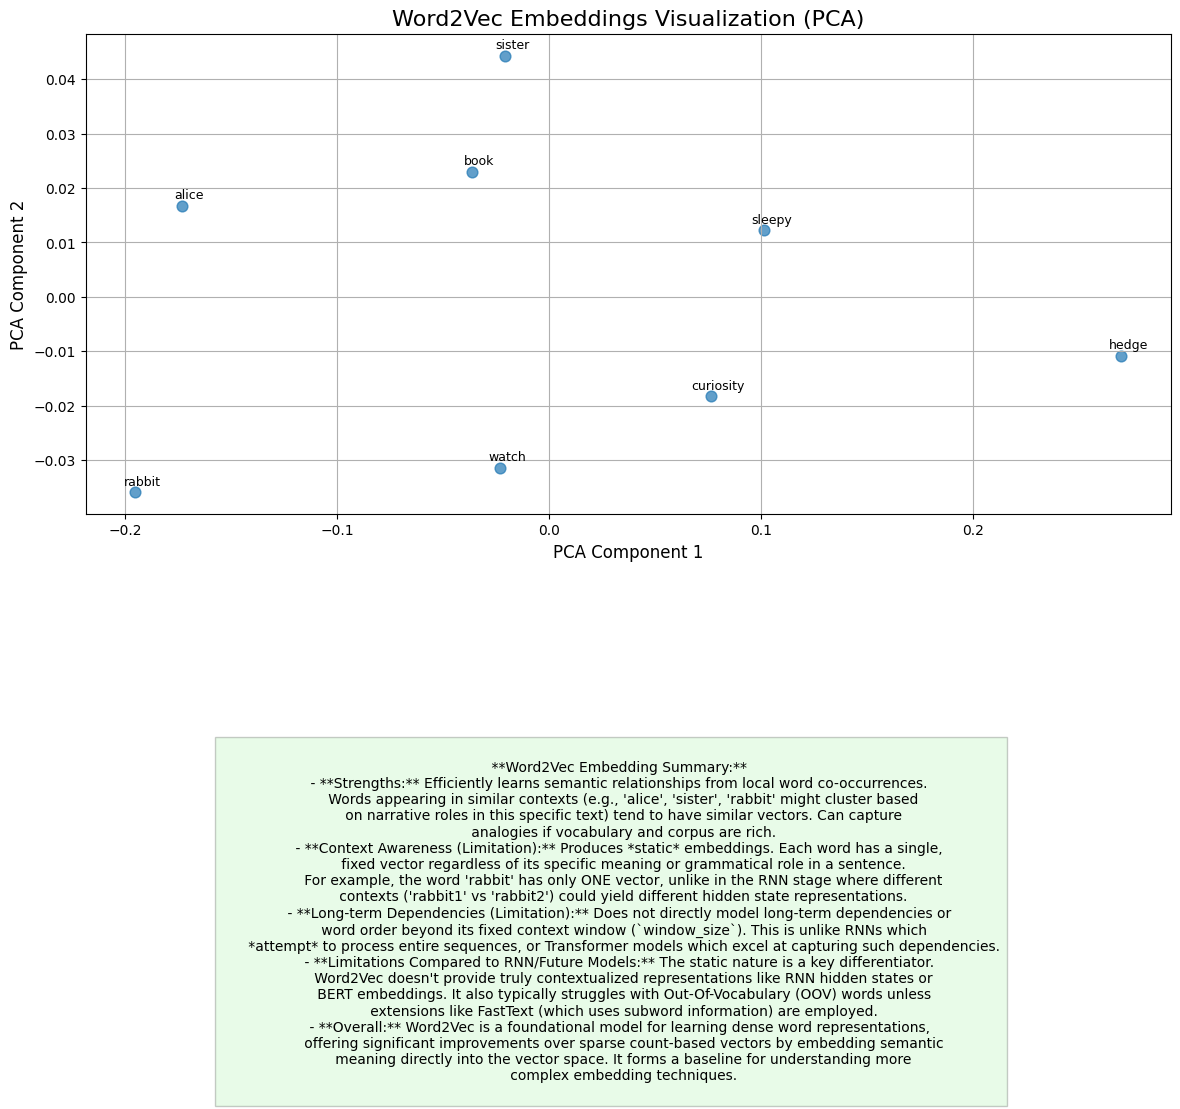

In [5]:
# Filter for words actually in the model's vocabulary
# Ensure core_comparison_words is defined from the previous cell or uncomment above
if 'core_comparison_words' not in locals():
    core_comparison_words = ['alice', 'rabbit', 'sister', 'book', 'watch', 'curiosity', 'sleepy', 'hedge']
    print("Warning: 'core_comparison_words' was not defined, using default set for plot.")


words_in_vocab_for_plot = sorted([word for word in core_comparison_words if word in word2vec_model.wv.index_to_key])

# Fallback if too few core words are available (e.g., less than 3 words to plot)
if len(words_in_vocab_for_plot) < 3:
    print(f"Warning: Only {len(words_in_vocab_for_plot)} core comparison words found in vocabulary: {words_in_vocab_for_plot}.")
    print("Attempting to use a fallback set of words for PCA plot by adding more words from vocabulary.")

    # Add some of the most frequent words from the vocabulary as fallback
    # (up to a certain number, ensuring they are not already included)
    num_fallback_words_to_add = 10 - len(words_in_vocab_for_plot) # Try to get up to 10 words total
    if num_fallback_words_to_add > 0:
        vocab_list = list(word2vec_model.wv.index_to_key)
        for i in range(min(num_fallback_words_to_add, len(vocab_list))):
            if vocab_list[i] not in words_in_vocab_for_plot:
                words_in_vocab_for_plot.append(vocab_list[i])
        words_in_vocab_for_plot = sorted(list(set(words_in_vocab_for_plot))) # Make unique and sort

    if len(words_in_vocab_for_plot) < 2: # Still not enough for PCA
         print("Fallback also resulted in too few words. Skipping PCA plot.")
         words_in_vocab_for_plot = [] # Empty list to ensure plotting logic is skipped

print(f"\nWords selected for PCA plot: {words_in_vocab_for_plot}")


# Proceed with plotting if we have at least 2 words (PCA needs n_samples >= n_components)
if words_in_vocab_for_plot and len(words_in_vocab_for_plot) >= 2:
    embedding_matrix = np.array([word2vec_model.wv[word] for word in words_in_vocab_for_plot])
    print(f"\nShape of embedding matrix for PCA: {embedding_matrix.shape}")

    # PCA Transformation
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embedding_matrix)

    # Plotting
    plt.figure(figsize=(14, 10)) # Adjusted figure size for better layout with text
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=60) # Slightly larger points

    # Annotate points
    for i, word in enumerate(words_in_vocab_for_plot):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

    plt.title('Word2Vec Embeddings Visualization (PCA)', fontsize=16)
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    plt.grid(True)

    # Add summary text (this is crucial for comparison)
    summary_text = """
    **Word2Vec Embedding Summary:**
    - **Strengths:** Efficiently learns semantic relationships from local word co-occurrences.
      Words appearing in similar contexts (e.g., 'alice', 'sister', 'rabbit' might cluster based
      on narrative roles in this specific text) tend to have similar vectors. Can capture
      analogies if vocabulary and corpus are rich.
    - **Context Awareness (Limitation):** Produces *static* embeddings. Each word has a single,
      fixed vector regardless of its specific meaning or grammatical role in a sentence.
      For example, the word 'rabbit' has only ONE vector, unlike in the RNN stage where different
      contexts ('rabbit1' vs 'rabbit2') could yield different hidden state representations.
    - **Long-term Dependencies (Limitation):** Does not directly model long-term dependencies or
      word order beyond its fixed context window (`window_size`). This is unlike RNNs which
      *attempt* to process entire sequences, or Transformer models which excel at capturing such dependencies.
    - **Limitations Compared to RNN/Future Models:** The static nature is a key differentiator.
      Word2Vec doesn't provide truly contextualized representations like RNN hidden states or
      BERT embeddings. It also typically struggles with Out-Of-Vocabulary (OOV) words unless
      extensions like FastText (which uses subword information) are employed.
    - **Overall:** Word2Vec is a foundational model for learning dense word representations,
      offering significant improvements over sparse count-based vectors by embedding semantic
      meaning directly into the vector space. It forms a baseline for understanding more
      complex embedding techniques.
    """
    # Adjust figtext y-position if needed based on your plot's appearance
    plt.figtext(0.5, -0.18, summary_text, ha="center", fontsize=10, bbox={"facecolor":"lightgreen", "alpha":0.2, "pad":5}, wrap=True)

    plt.subplots_adjust(bottom=0.4) # Adjust layout to make more space for the summary text below
    plt.show()

else:
    print("Could not create PCA plot: Not enough words found in vocabulary for plotting (need at least 2).")

## 6. Attempting Text Autocompletion with Word2Vec (Demonstrating Limitations)

Word2Vec is designed to learn static embeddings that capture semantic relationships between words, not to model sequential probabilities like an RNN language model.
However, to illustrate its different nature and its limitations for sequence generation tasks like autocompletion, we can try a naive approach: given a seed text, we'll take the last word and find its most similar word in the Word2Vec model to append next.
We expect this to primarily generate lists of related words rather than coherent sentences.

In [13]:
def generate_text_word2vec_naive(w2v_model_or_vectors, seed_text_str, num_words_to_generate):
    """
    Naively "generates" text by appending the most similar word to the last word in the sequence.
    """
    generated_text = seed_text_str.lower()
    current_word_list = generated_text.split()

    # Determine if we have the full model or just KeyedVectors
    if hasattr(w2v_model_or_vectors, 'wv'):
        vectors = w2v_model_or_vectors.wv  # It's a full Word2Vec model object
    else:
        vectors = w2v_model_or_vectors      # Assume it's already a KeyedVectors instance

    for _ in range(num_words_to_generate):
        if not current_word_list:
            print("Error: Current word list is empty.")
            break
        
        last_word = current_word_list[-1]

        if last_word in vectors: # Use the 'vectors' object here
            try:
                similar_words_tuples = vectors.most_similar(last_word, topn=5) # And here
                next_word = None
                for sim_word, score in similar_words_tuples:
                    if sim_word not in current_word_list[-3:]: 
                        next_word = sim_word
                        break
                if next_word is None and similar_words_tuples:
                     next_word = similar_words_tuples[0][0]
                
                if not next_word:
                    print(f"Warning: No suitable similar words found for '{last_word}'. Stopping.")
                    break
            except KeyError:
                print(f"Warning: Word '{last_word}' not in model vocabulary during most_similar. Stopping.")
                break
            except Exception as e:
                print(f"An error occurred finding similar word for '{last_word}': {e}. Stopping.")
                break
        else:
            print(f"Warning: Last word '{last_word}' not in Word2Vec vocabulary. Stopping generation.")
            break
            
        generated_text += " " + next_word
        current_word_list.append(next_word)
        
    return generated_text

# Test "autocompletion" with Word2Vec
if 'word2vec_model' in locals() and word2vec_model is not None:
    seed_texts_for_autocomplete = [
        "alice was",
        "the white rabbit",
        "alice thought it was very",
        "her sister on the bank and", # Longer seed
        "burning with curiosity she ran" # Even longer seed
    ]
    
    num_generated_words_w2v = 10 # Generate 10 words

    print("\n--- Word2Vec Naive 'Autocompletion' Results ---")
    for seed in seed_texts_for_autocomplete:
        generated_sequence_w2v = generate_text_word2vec_naive(word2vec_model, seed, num_generated_words_w2v)
        print(f"Seed: '{seed}'\n  -> Generated: '{generated_sequence_w2v}'\n")
else:
    print("Word2Vec model not available for autocompletion test.")



--- Word2Vec Naive 'Autocompletion' Results ---
Seed: 'alice was'
  -> Generated: 'alice was to and on a book it the out and on'

Seed: 'the white rabbit'
  -> Generated: 'the white rabbit a and on rabbit a and on rabbit a and'

Seed: 'alice thought it was very'
  -> Generated: 'alice thought it was very a and on rabbit a and on rabbit a and'

Seed: 'her sister on the bank and'
  -> Generated: 'her sister on the bank and on a book it the out and on a book'

Seed: 'burning with curiosity she ran'
  -> Generated: 'burning with curiosity she ran and on a book it the out and on a'



## 7. Using a Pre-trained Word2Vec Model

To see the difference a large and diverse training corpus makes, let's load a well-known pre-trained Word2Vec model. Google's model trained on a part of the Google News dataset contains 300-dimensional vectors for 3 million words and phrases.

In [9]:
model_name_pretrained = 'word2vec-google-news-300' # This is a large model

try:
    print(f"Loading pre-trained Word2Vec model: '{model_name_pretrained}'...")
    # The device argument is not directly used by Word2Vec model loading in Gensim as it's CPU-based.
    pretrained_w2v_model = api.load(model_name_pretrained)
    print(f"Successfully loaded pre-trained Word2Vec model.")
    print(f"Vocabulary size: {len(pretrained_w2v_model.key_to_index)}") # In older gensim, it might be len(pretrained_w2v_model.vocab)
    print(f"Vector dimension: {pretrained_w2v_model.vector_size}")
except Exception as e:
    print(f"Error loading pre-trained Word2Vec model: {e}")
    print("Please ensure you have an internet connection for the download.")
    pretrained_w2v_model = None

Loading pre-trained Word2Vec model: 'word2vec-google-news-300'...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Successfully loaded pre-trained Word2Vec model.
Vocabulary size: 3000000
Vector dimension: 300


## 8. Explore Word Embeddings (from Pre-trained Model)

In [10]:
if pretrained_w2v_model:
    core_comparison_words_alice = ['alice', 'rabbit', 'sister', 'book', 'watch', 'curiosity', 'sleepy', 'hedge']
    # Add some general words that are definitely in Google News
    general_words_for_exploration = ['king', 'queen', 'man', 'woman', 'france', 'paris', 'germany', 'berlin']
    
    words_to_test_pretrained = core_comparison_words_alice + general_words_for_exploration
    
    print("\n--- Exploring Pre-trained Word2Vec Embeddings ---")
    
    # Check some Alice words
    for word in ['alice', 'rabbit', 'hatter']: # 'hatter' might be interesting too
        if word in pretrained_w2v_model:
            print(f"\nWords most similar to '{word}' (pre-trained):")
            try:
                print(pretrained_w2v_model.most_similar(word, topn=5))
            except KeyError:
                print(f"'{word}' present but error in most_similar (rare).")
        else:
            print(f"'{word}' not in pre-trained vocabulary.")
            
    # Similarity
    print("\n--- Specific Similarities (Pre-trained) ---")
    if 'king' in pretrained_w2v_model and 'queen' in pretrained_w2v_model:
        print(f"Similarity between 'king' and 'queen': {pretrained_w2v_model.similarity('king', 'queen'):.4f}")
    if 'man' in pretrained_w2v_model and 'woman' in pretrained_w2v_model:
        print(f"Similarity between 'man' and 'woman': {pretrained_w2v_model.similarity('man', 'woman'):.4f}")
    if 'france' in pretrained_w2v_model and 'paris' in pretrained_w2v_model:
        print(f"Similarity between 'france' and 'paris': {pretrained_w2v_model.similarity('france', 'paris'):.4f}")
    if 'alice' in pretrained_w2v_model and 'wonderland' in pretrained_w2v_model: # wonderland might be a good test
        print(f"Similarity between 'alice' and 'wonderland': {pretrained_w2v_model.similarity('alice', 'wonderland'):.4f}")
    else:
        print("'wonderland' might not be in vocab as a single token or common enough.")


    # Analogies
    print("\n--- Word Analogies (Pre-trained) ---")
    try:
        analogy = pretrained_w2v_model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
        print(f"'king' - 'man' + 'woman' = {analogy}")
    except KeyError as e:
        print(f"Could not perform analogy, word not in pre-trained vocabulary: {e}")
    
    try:
        analogy_capital = pretrained_w2v_model.most_similar(positive=['berlin', 'france'], negative=['germany'], topn=1)
        print(f"'berlin' - 'germany' + 'france' = {analogy_capital}")
    except KeyError as e:
        print(f"Could not perform capital analogy, word not in pre-trained vocabulary: {e}")
else:
    print("Pre-trained Word2Vec model not loaded.")


--- Exploring Pre-trained Word2Vec Embeddings ---

Words most similar to 'alice' (pre-trained):
[('nikki', 0.6746106743812561), ('christina', 0.661102831363678), ('joshua', 0.6600386500358582), ('joel', 0.6595911979675293), ('disney', 0.6571455597877502)]

Words most similar to 'rabbit' (pre-trained):
[('rabbits', 0.7532057166099548), ('fox', 0.648273766040802), ('bunny', 0.6440337300300598), ('possum', 0.6298685073852539), ('squirrel', 0.6263884902000427)]

Words most similar to 'hatter' (pre-trained):
[('hatters', 0.5998439192771912), ('powdered_wig', 0.5145496726036072), ('hatmakers', 0.511846661567688), ('mad_hatter', 0.48737001419067383), ('cravats', 0.4779871106147766)]

--- Specific Similarities (Pre-trained) ---
Similarity between 'king' and 'queen': 0.6511
Similarity between 'man' and 'woman': 0.7664
Similarity between 'france' and 'paris': 0.5551
Similarity between 'alice' and 'wonderland': 0.3020

--- Word Analogies (Pre-trained) ---
'king' - 'man' + 'woman' = [('queen', 0.

## 9. Select Words and Visualize Embeddings with PCA (from Pre-trained Model)

Now, let's visualize some of these high-quality pre-trained Word2Vec embeddings. We'll use our `core_comparison_words_alice` (words from the Alice text) if they exist in the pre-trained model's vocabulary, and also add some general words for which the pre-trained model should have strong representations. The plot should ideally show more distinct semantic clustering compared to the model trained on our very small "Alice" corpus.


Words selected for PCA plot (pre-trained): ['alice', 'book', 'curiosity', 'france', 'happy', 'hedge', 'king', 'man', 'paris', 'queen', 'rabbit', 'sad', 'sister', 'sleepy', 'watch', 'woman']

Shape of embedding matrix for PCA (pre-trained): (16, 300)


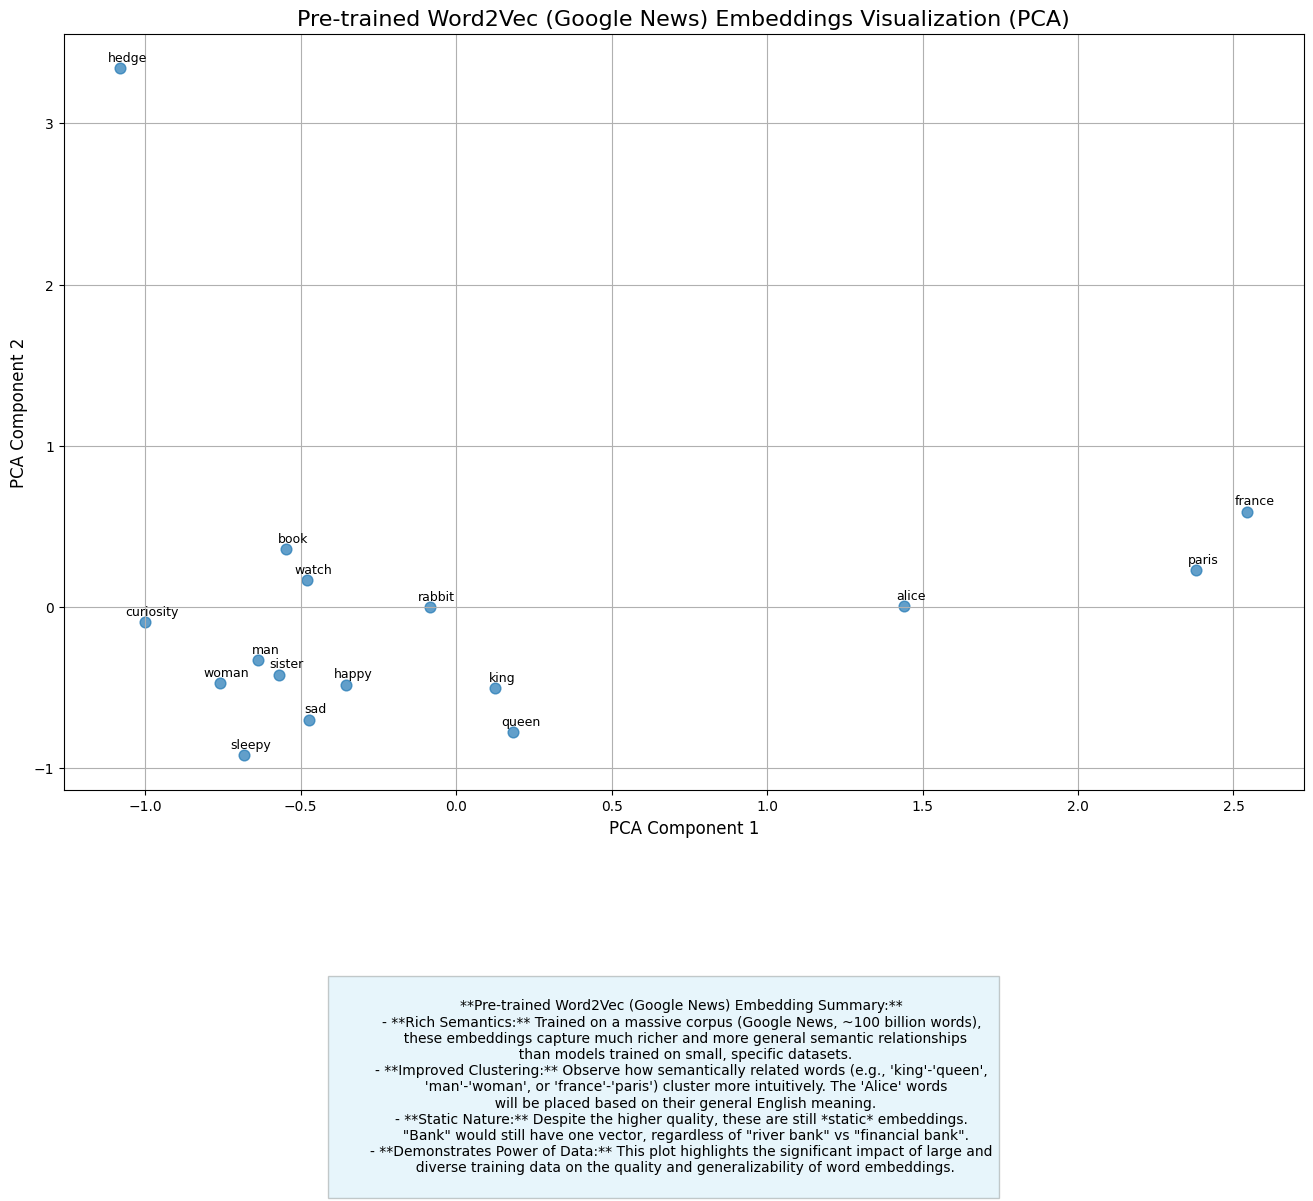

In [16]:
if 'pretrained_w2v_model' in locals() and pretrained_w2v_model is not None:

    # Words from Alice text, plus some general words for better illustration with pre-trained model
    core_comparison_words_alice = ['alice', 'rabbit', 'sister', 'book', 'watch', 'curiosity', 'sleepy', 'hedge']
    general_comparison_words = ['king', 'queen', 'man', 'woman', 'happy', 'sad', 'france', 'paris'] # Common words for good analogies/clusters
    
    words_for_plot_combined = core_comparison_words_alice + general_comparison_words
    
    # Filter for words actually in the pre-trained model's vocabulary
    # The pre-trained model object itself is the KeyedVectors instance
    words_in_vocab_for_plot_pretrained = sorted(
        [word for word in words_for_plot_combined if word in pretrained_w2v_model.key_to_index]
    )

    # Fallback if too few words are available (less likely with pre-trained model but good practice)
    if len(words_in_vocab_for_plot_pretrained) < 3:
        print(f"Warning: Only {len(words_in_vocab_for_plot_pretrained)} selected words found in pre-trained vocabulary: {words_in_vocab_for_plot_pretrained}.")
        print("Attempting to use a fallback set of common words for PCA plot.")
        # Fallback: select some very common English words
        fallback_words = ['cat', 'dog', 'house', 'tree', 'car', 'road', 'love', 'hate', 'big', 'small']
        
        # Add fallback words that are in the vocab and not already included
        for fw in fallback_words:
            if fw in pretrained_w2v_model.key_to_index and fw not in words_in_vocab_for_plot_pretrained:
                words_in_vocab_for_plot_pretrained.append(fw)
        words_in_vocab_for_plot_pretrained = sorted(list(set(words_in_vocab_for_plot_pretrained)))

        if len(words_in_vocab_for_plot_pretrained) < 2:
             print("Fallback also resulted in too few words. Skipping PCA plot for pre-trained model.")
             words_in_vocab_for_plot_pretrained = []

    print(f"\nWords selected for PCA plot (pre-trained): {words_in_vocab_for_plot_pretrained}")

    # Proceed with plotting if we have at least 2 words
    if words_in_vocab_for_plot_pretrained and len(words_in_vocab_for_plot_pretrained) >= 2:
        # Get embeddings from the pre-trained model
        embedding_matrix_pretrained = np.array(
            [pretrained_w2v_model[word] for word in words_in_vocab_for_plot_pretrained]
        )
        print(f"\nShape of embedding matrix for PCA (pre-trained): {embedding_matrix_pretrained.shape}")

        # PCA Transformation
        pca_pretrained = PCA(n_components=2)
        embeddings_2d_pretrained = pca_pretrained.fit_transform(embedding_matrix_pretrained)

        # Plotting
        plt.figure(figsize=(16, 12)) # Adjusted for better label visibility
        plt.scatter(embeddings_2d_pretrained[:, 0], embeddings_2d_pretrained[:, 1], alpha=0.7, s=60)

        # Annotate points
        for i, word in enumerate(words_in_vocab_for_plot_pretrained):
            plt.annotate(word, (embeddings_2d_pretrained[i, 0], embeddings_2d_pretrained[i, 1]),
                         textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

        plt.title('Pre-trained Word2Vec (Google News) Embeddings Visualization (PCA)', fontsize=16)
        plt.xlabel('PCA Component 1', fontsize=12)
        plt.ylabel('PCA Component 2', fontsize=12)
        plt.grid(True)

        # Add summary text
        summary_text_pretrained = """
        **Pre-trained Word2Vec (Google News) Embedding Summary:**
        - **Rich Semantics:** Trained on a massive corpus (Google News, ~100 billion words),
          these embeddings capture much richer and more general semantic relationships
          than models trained on small, specific datasets.
        - **Improved Clustering:** Observe how semantically related words (e.g., 'king'-'queen',
          'man'-'woman', or 'france'-'paris') cluster more intuitively. The 'Alice' words
          will be placed based on their general English meaning.
        - **Static Nature:** Despite the higher quality, these are still *static* embeddings.
          "Bank" would still have one vector, regardless of "river bank" vs "financial bank".
        - **Demonstrates Power of Data:** This plot highlights the significant impact of large and
          diverse training data on the quality and generalizability of word embeddings.
        """
        plt.figtext(0.5, -0.08, summary_text_pretrained, ha="center", fontsize=10,
                    bbox={"facecolor":"skyblue", "alpha":0.2, "pad":5}, wrap=True) # Different color for distinction

        plt.subplots_adjust(bottom=0.25) # Adjust layout for summary text
        plt.show()

    else:
        print("Could not create PCA plot for pre-trained model: Not enough words found in vocabulary for plotting.")
else:
    print("Pre-trained Word2Vec model ('pretrained_w2v_model') not loaded. Skipping PCA visualization.")

## 10. Attempting Text Autocompletion with Pre-trained Word2Vec

In [14]:
if pretrained_w2v_model:
    print("\n--- Pre-trained Word2Vec Naive 'Autocompletion' Results ---")
    for seed in seed_texts_for_autocomplete: # Using the same seeds as before
        generated_sequence_pretrained_w2v = generate_text_word2vec_naive(pretrained_w2v_model, seed, num_generated_words_w2v)
        print(f"Seed: '{seed}'\n  -> Generated: '{generated_sequence_pretrained_w2v}'\n")
else:
    print("Pre-trained Word2Vec model not available for autocompletion test.")


--- Pre-trained Word2Vec Naive 'Autocompletion' Results ---
Seed: 'alice was'
  -> Generated: 'alice was is isn'ta wasn'ta it'sa that'sa That'sa It'sa it'sa that'sa That'sa'

Seed: 'the white rabbit'
  -> Generated: 'the white rabbit rabbits animals animal Animal Animals Animals_Peta Animals_PETA PETA PeTA founder_Ingrid_Newkirk'

Seed: 'alice thought it was very'
  -> Generated: 'alice thought it was very extremely incredibly unbelievably amazingly astonishingly astoundingly unbelievably incredibly extremely very'

Seed: 'her sister on the bank and'
  -> Generated: 'her sister on the bank and'

Seed: 'burning with curiosity she ran'
  -> Generated: 'burning with curiosity she ran went came brought bring bringing brining brought bring bringing brining'



## 11. Word2Vec Stage Conclusion - Performance and Limitations Summary

In this notebook, we explored Word2Vec, a pivotal technique for learning static word embeddings. We conducted two sets of experiments: first, training a Word2Vec model from scratch on our small "Alice in Wonderland" corpus, and second, utilizing a comprehensive pre-trained Word2Vec model (Google News 300-dim). Through these, we examined word similarity, analogy-solving capabilities, PCA visualizations, and even attempted a naive form of text "autocompletion" to highlight its characteristics.

**Key Observations from Our Word2Vec Experiments:**

1.  **Semantic Similarity & Analogies (Strengths):**
    * **Pre-trained Model:** The Google News pre-trained model showcased Word2Vec's classic strength in capturing rich semantic relationships. It produced intuitive similarity scores (e.g., "king" was highly similar to "queen") and successfully resolved analogies like `king - man + woman ≈ queen`. The PCA plot for the pre-trained model further illustrated a well-structured semantic space, with related concepts clustering meaningfully.
    * **Scratch-Trained Model:** Our model trained on the "Alice" snippet also learned word vectors. However, due to the very small and specific nature of the corpus, the learned similarities were highly contextual to that text and less generalizable. Cosine similarities between many word pairs were extremely high (often >0.99), and the PCA plot showed a less defined semantic space compared to the pre-trained one. This vividly demonstrated the impact of corpus size and diversity on embedding quality.

2.  **Static Nature of Embeddings (Inherent Characteristic & Limitation):**
    * Both models produce **static embeddings**: one unique vector per word, regardless of its surrounding context. This means polysemous words (like "bank") would have a single, averaged representation. This is a fundamental difference from contextual models like RNNs (whose hidden states vary) or BERT.

3.  **Unsuitability for Sequence Generation (Demonstrated by Naive Autocompletion):**
    We attempted to "autocomplete" text by naively appending the word most similar to the previously generated word.
    * **Scratch Model Output Example:** `Seed: 'alice was' -> Generated: 'alice was to and on a book it the out and on'`
    * **Pre-trained Model Output Example:** `Seed: 'the white rabbit' -> Generated: 'the white rabbit rabbits animals animal Animal Animals Animals_Peta Animals_PETA PETA PeTA founder_Ingrid_Newkirk'`
    * **Interpretation:** These outputs, while amusing, clearly show that Word2Vec is **not a language model designed for sequence generation**. The "generated" text lacks grammatical coherence and narrative flow. It primarily strings together words that are semantically close to the *previous* word in isolation, highlighting its focus on word-level semantic similarity rather than sequential probability or grammatical structure. The pre-trained model produced more diverse semantic chains but was equally unsuited for coherent sentence formation. This contrasts with RNNs, which, despite their own flaws in long-term memory, are at least architected to predict based on sequence.

4.  **Out-of-Vocabulary (OOV) Words:**
    * Our scratch model's vocabulary was limited to the "Alice" text. The pre-trained model has a vast vocabulary, but even it can encounter OOV words for highly specialized or very new terms. Standard Word2Vec offers no mechanism to create embeddings for unseen words.

**Word2Vec in the "EmbedEvolution" Context:**

Word2Vec represented a major advancement by providing an **efficient and effective method to learn high-quality static word embeddings**. Its ability to capture semantic relationships like similarity and analogy from large text corpora was transformative for many NLP tasks at the time, such as text classification, information retrieval, and as feature inputs for other models.

However, its static nature (one vector per word, inability to disambiguate polysemy) and its focus on individual word representations rather than dynamic contextual understanding or sequence modeling were key limitations that spurred further research.

**Next Steps:**

The journey continues! Having explored the strengths and limitations of static word embeddings with Word2Vec, the next major leap in our "EmbedEvolution" series is to dive into the world of **contextual embeddings** with **BERT (Bidirectional Encoder Representations from Transformers)**. BERT revolutionized NLP by providing word representations that change based on the surrounding words, addressing the key limitation of polysemy and capturing much deeper nuances of language.